In [1]:
!pip install gdown
!pip install tensorflowjs
import gdown
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
zip_id = "1ar0oM1-7IPeY3x4Qqi3QQPiN3mxSrzco"
gdown.download(f"https://drive.google.com/uc?id={zip_id}", output="dataset.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1ar0oM1-7IPeY3x4Qqi3QQPiN3mxSrzco
From (redirected): https://drive.google.com/uc?id=1ar0oM1-7IPeY3x4Qqi3QQPiN3mxSrzco&confirm=t&uuid=0f7a814a-d73b-4fde-aa1e-b2090c373c9a
To: c:\Users\saflo\jupyter\Capstone\dataset.zip
  6%|▌         | 200M/3.20G [01:01<14:20, 3.49MB/s] 

KeyboardInterrupt: 

In [6]:
with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall()

In [7]:
csv_url='https://drive.google.com/uc?id=1Em6aYEQwqyuquhqDopKSCDtJQ4tlvjfj'
df = pd.read_csv(csv_url)

label_map = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}

df['label'] = df['diagnosis'].map(label_map)

# Cek hasil
print(df.head())

                 id_code  diagnosis  label
0  20170413102628830.jpg          0  No DR
1  20170413111955404.jpg          0  No DR
2  20170413112015395.jpg          0  No DR
3  20170413112017305.jpg          0  No DR
4  20170413112528859.jpg          0  No DR


diagnosis
0    6266
2    4477
4     913
1     630
3     236
Name: count, dtype: int64


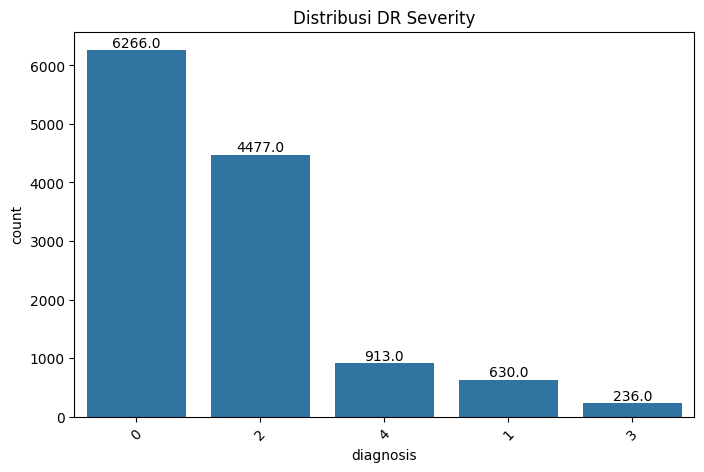

In [8]:
# Tampilkan count per label
print(df['diagnosis'].value_counts())

# Buat plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='diagnosis', data=df, order=df['diagnosis'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribusi DR Severity")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.show()


In [9]:
# Folder gambar asli
image_folder = "DR_grading"

# Folder output
output_base = "sorted_dataset"

# Iterasi dan salin gambar ke folder sesuai diagnosis
for _, row in df.iterrows():
    filename = row['id_code']
    diagnosis = str(row['diagnosis'])
    src = os.path.join(image_folder, filename)
    dst_dir = os.path.join(output_base, diagnosis)
    dst = os.path.join(dst_dir, filename)

    os.makedirs(dst_dir, exist_ok=True)

    if os.path.exists(src):
        shutil.move(src, dst)
    else:
        print(f"File tidak ditemukan: {src}")

shutil.rmtree(image_folder)

  6%|▋         | 200M/3.20G [03:09<47:13, 1.06MB/s]


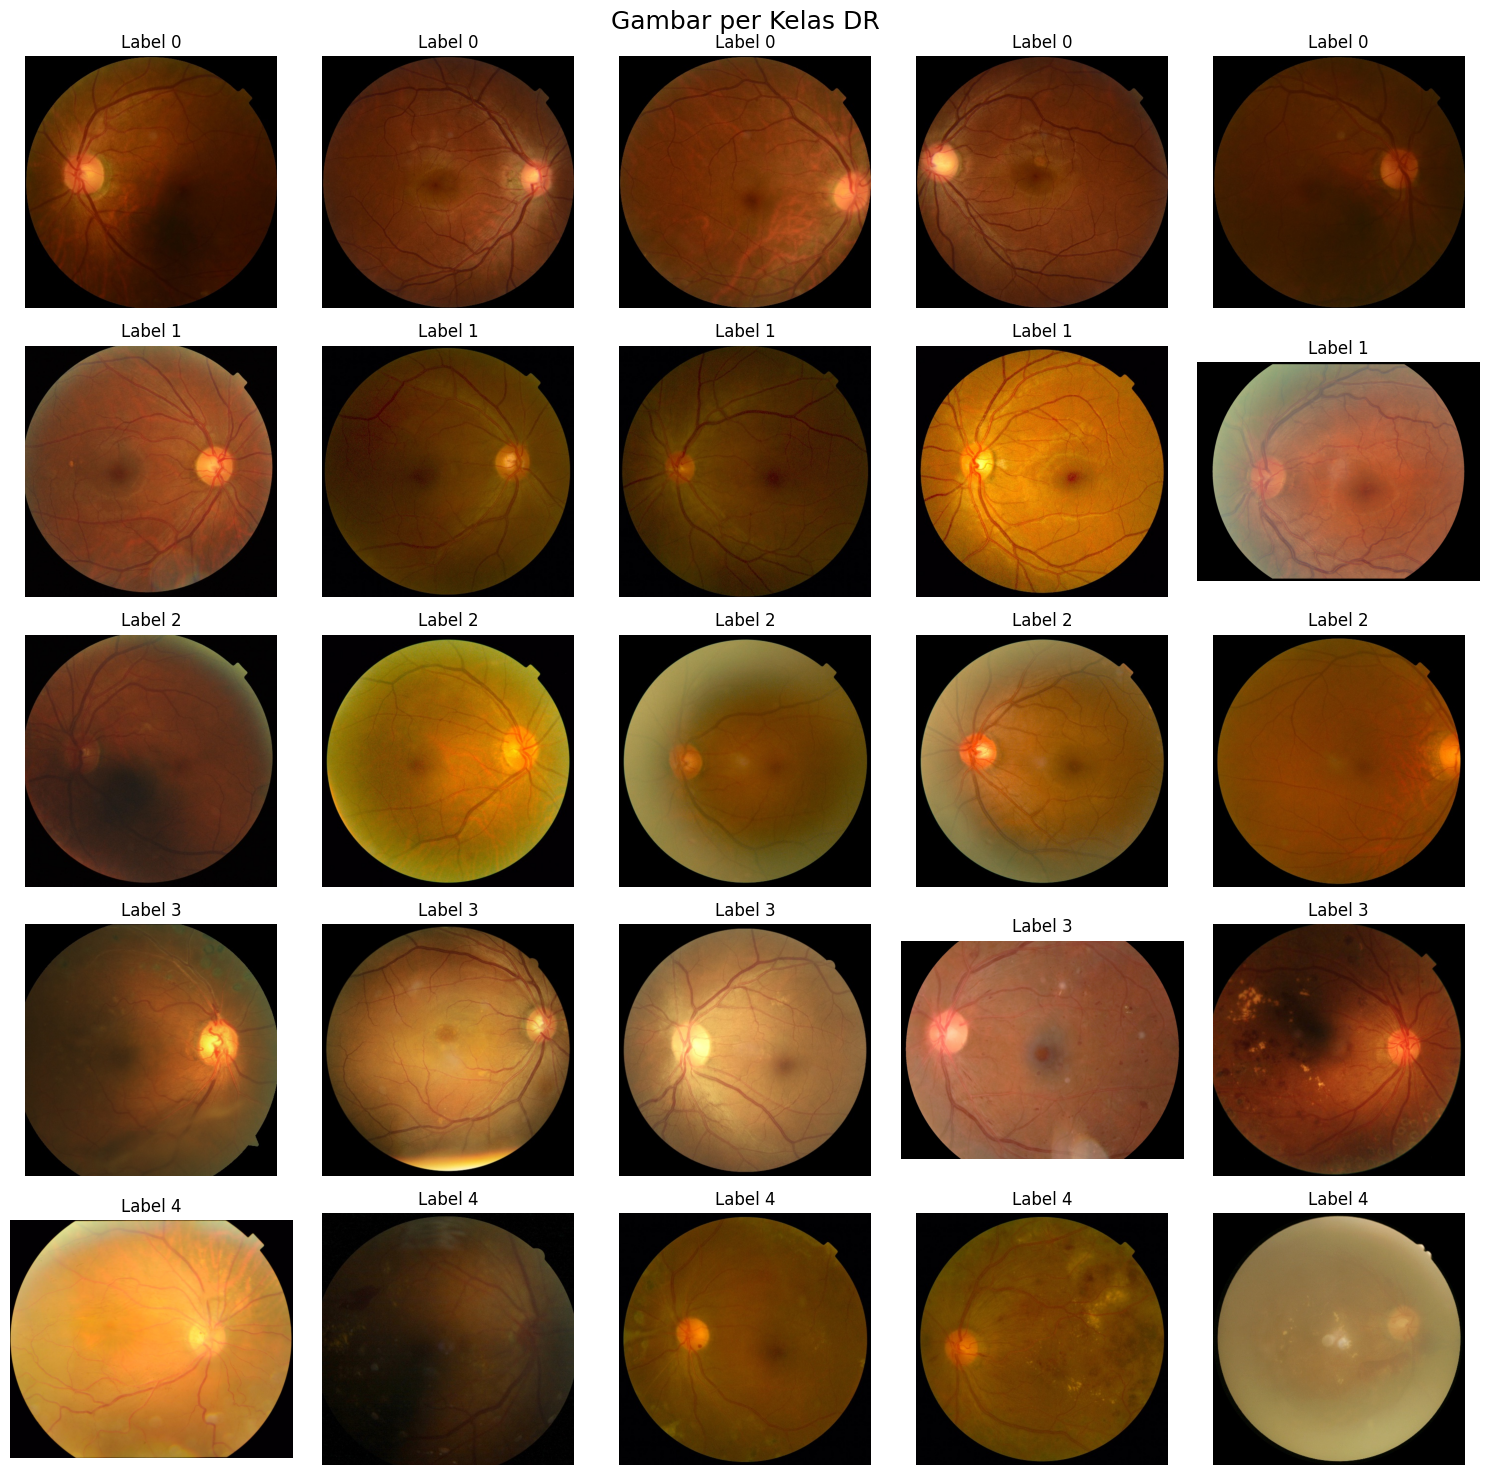

In [10]:
# Folder dasar dataset tersortir
base_folder = "sorted_dataset"
labels = ['0', '1', '2', '3', '4']
images_per_label = 5

# Setup plot grid 5x5
plt.figure(figsize=(15, 15))

img_index = 1
for label in labels:
    folder = os.path.join(base_folder, label)
    images = os.listdir(folder)[:images_per_label]  # Ambil 5 gambar pertama
    for img_name in images:
        img_path = os.path.join(folder, img_name)
        try:
            img = mpimg.imread(img_path)
            plt.subplot(5, 5, img_index)
            plt.imshow(img)
            plt.title(f"Label {label}")
            plt.axis('off')
            img_index += 1
        except Exception as e:
            print(f"Gagal buka gambar {img_path}: {e}")

plt.suptitle("Gambar per Kelas DR", fontsize=18)
plt.tight_layout()
plt.show()

In [11]:
source_base = 'sorted_dataset'
target_base = 'augmented_dataset'

# Buat target folder untuk masing-masing kelas
for label in ['0', '1', '2', '3', '4']:
    os.makedirs(os.path.join(target_base, label), exist_ok=True)


In [12]:
augmentor = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    channel_shift_range=20.0,
    fill_mode="nearest"
)


def augment_images(label, target_count):
    source_folder = os.path.join(source_base, label)
    target_folder = os.path.join(target_base, label)
    image_files = os.listdir(source_folder)
    current_count = len(image_files)

    if current_count >= target_count:
        # Salin semua saja kalau cukup
        for img_name in image_files:
            src_path = os.path.join(source_folder, img_name)
            dst_path = os.path.join(target_folder, img_name)
            shutil.copy(src_path, dst_path)
    else:
        # Salin yang ada
        for img_name in image_files:
            shutil.copy(os.path.join(source_folder, img_name), os.path.join(target_folder, img_name))

        # Augment sampai memenuhi target_count
        print(f"Augmenting label {label} dari {current_count} ke {target_count}")
        i = 0
        while len(os.listdir(target_folder)) < target_count:
            img_name = image_files[i % current_count]
            img_path = os.path.join(source_folder, img_name)

            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            # Simpan hasil augmentasi
            gen = augmentor.flow(x, batch_size=1)
            aug_img = next(gen)[0]
            save_img(os.path.join(target_folder, f"aug_{i}_{img_name}"), aug_img)
            i += 1


In [16]:
# Target jumlah per kelas untuk augmentasi minoritas
target_per_class = {
    '0': 7000,
    '1': 5000,
    '2': 7000,
    '3': 5000,
    '4': 5000
}


for label, target in target_per_class.items():
    augment_images(label, target)

Augmenting label 0 dari 6266 ke 7000
Augmenting label 1 dari 630 ke 5000
Augmenting label 2 dari 4477 ke 7000
Augmenting label 3 dari 236 ke 5000
Augmenting label 4 dari 913 ke 5000


In [17]:
# from google.colab import files
base_dir = 'augmented_dataset'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    label_dir = os.path.join(base_dir, label)
    if os.path.isdir(label_dir):
        for fname in os.listdir(label_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(base_dir, label, fname))
                labels.append(int(label))

df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

In [15]:
# Simpan CSV ke dalam folder augmented_dataset
csv_path = os.path.join(base_dir, 'augmented_dataset_info.csv')
df.to_csv(csv_path, index=False)


# Kompres seluruh folder
shutil.make_archive("augmented_dataset", 'zip', base_dir)

# Download file ZIP ke lokal
files.download("augmented_dataset.zip")

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (200, 200)
DATA_DIR = "augmented_dataset"
SEED = 123

# 1. Load semua data tanpa split
full_ds = image_dataset_from_directory(
    DATA_DIR,
    seed=SEED,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# 2. Hitung total jumlah batch
dataset_size = full_ds.cardinality().numpy()
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# 3. Split dengan take() dan skip()
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

# 4. Ambil nama label
class_names = full_ds.class_names
print("Label:", class_names)


Found 29000 files belonging to 5 classes.
Label: ['0', '1', '2', '3', '4']


In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


base_model = MobileNetV2(input_shape=(200, 200, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(200, 200, 3)),  # Bisa diganti dengan preprocess_input
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(200, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # Ganti 5 sesuai jumlah kelas kamu
])

C:\Users\saflo\AppData\Local\Temp\ipykernel_31924\1820175157.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(200, 200, 3),
c:\Users\saflo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       256,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,515,189 (9.59 MB)

 Trainable params: 257,205 (1004.71 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
print(df.columns)


Index(['filepath', 'label'], dtype='object')


In [23]:
labels = df['label'].astype(int)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 0.8285714285714286, 1: 1.16, 2: 0.8285714285714286, 3: 1.16, 4: 1.16}


In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 121s 212ms/step - accuracy: 0.4879 - loss: 1.2368 - val_accuracy: 0.6209 - val_loss: 0.9760
Epoch 2/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 116s 213ms/step - accuracy: 0.6084 - loss: 0.9706 - val_accuracy: 0.6355 - val_loss: 0.9313
Epoch 3/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 112s 205ms/step - accuracy: 0.6335 - loss: 0.9082 - val_accuracy: 0.6554 - val_loss: 0.8678
Epoch 4/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 125s 230ms/step - accuracy: 0.6489 - loss: 0.8618 - val_accuracy: 0.6777 - val_loss: 0.8298
Epoch 5/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 147s 270ms/step - accuracy: 0.6648 - loss: 0.8358 - val_accuracy: 0.6903 - val_loss: 0.8042
Epoch 6/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 143s 262ms/step - accuracy: 0.6745 - loss: 0.8111 - val_accuracy: 0.6644 - val_loss: 0.8447
Epoch 7/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 148s 272ms/step - accuracy: 0.6804 - loss: 0.7876 - val_accuracy: 0.6944 - val_loss: 0.7813
Epoch 8/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 146s 268ms/step - accuracy: 0.6878 -

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

# Ambil semua data dan label dari test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

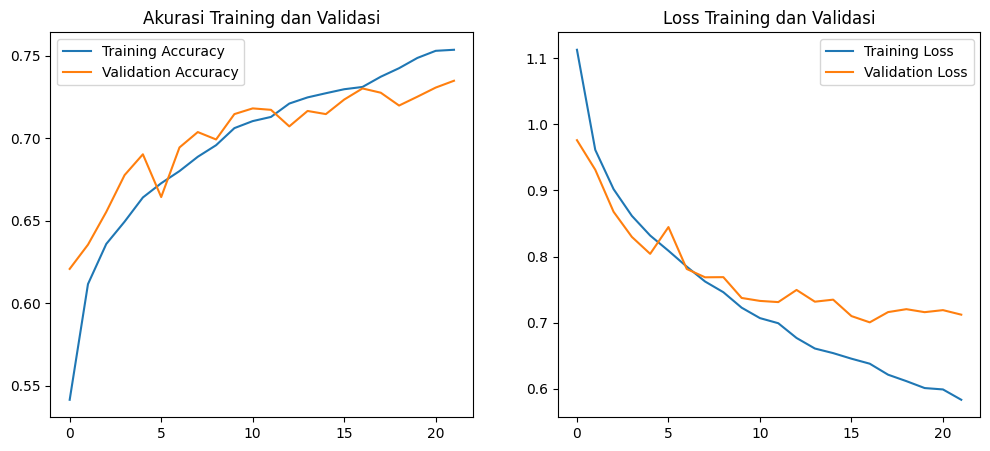

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Training dan Validasi')
plt.legend()

plt.show()

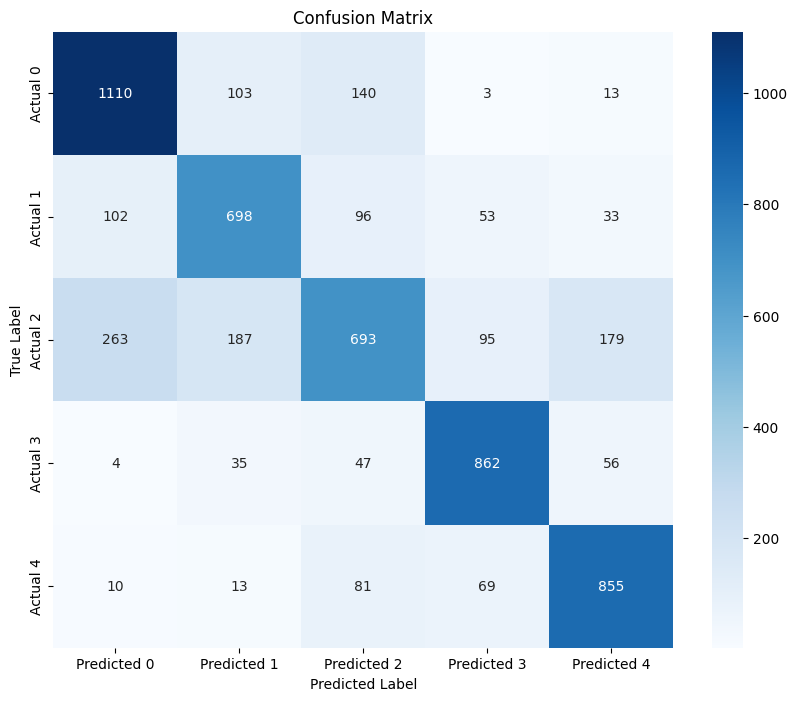

Classification Report:

              precision    recall  f1-score   support

           0     0.7455    0.8108    0.7768      1369
           1     0.6737    0.7108    0.6918       982
           2     0.6556    0.4891    0.5602      1417
           3     0.7967    0.8586    0.8265      1004
           4     0.7526    0.8317    0.7902      1028

    accuracy                         0.7272      5800
   macro avg     0.7248    0.7402    0.7291      5800
weighted avg     0.7215    0.7272    0.7205      5800



In [28]:
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4]),
    index=[f"Actual {name}" for name in class_names],
    columns=[f"Predicted {name}" for name in class_names]
)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


In [30]:
from tensorflow.keras.preprocessing import image

# Path ke gambar yang ingin diuji
img_path = 'sorted_dataset/1/007-0033-000.jpg'

# 1. Load gambar
img = image.load_img(img_path, target_size=(256, 256))  # sesuai input model

# 2. Konversi ke array dan ekspansi dimensi (karena model expect batch)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
Predicted class: 1


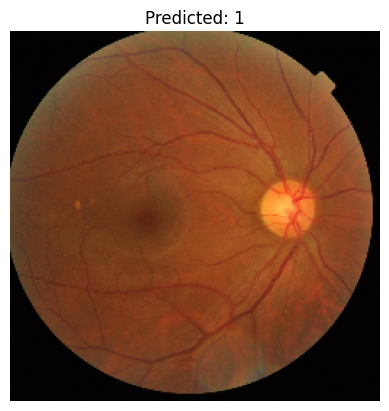

In [31]:
# Prediksi
pred = model.predict(img_array)
predicted_class = np.argmax(pred)

# Menampilkan hasil
print(f"Predicted class: {predicted_class}")

# Optional: tampilkan gambar dan hasil prediksi
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()



In [32]:
print(f"Predicted class: {class_names[predicted_class]}")


Predicted class: 1


## Perbandingan 7:3

In [33]:
# 2. Hitung total jumlah batch
dataset_size = full_ds.cardinality().numpy()
train_size = int(0.7 * dataset_size)
val_size = dataset_size - train_size

# 3. Split 70:30
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size)

# 4. Ambil nama label
class_names = full_ds.class_names
print("Label:", class_names)

Label: ['0', '1', '2', '3', '4']


In [34]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 151s 237ms/step - accuracy: 0.7443 - loss: 0.6170 - val_accuracy: 0.7183 - val_loss: 0.7144
Epoch 2/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 146s 230ms/step - accuracy: 0.7390 - loss: 0.6216 - val_accuracy: 0.7164 - val_loss: 0.7172
Epoch 3/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 147s 232ms/step - accuracy: 0.7426 - loss: 0.6111 - val_accuracy: 0.7268 - val_loss: 0.7106
Epoch 4/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 174s 275ms/step - accuracy: 0.7477 - loss: 0.5962 - val_accuracy: 0.7312 - val_loss: 0.6899
Epoch 5/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 190s 299ms/step - accuracy: 0.7503 - loss: 0.5976 - val_accuracy: 0.7258 - val_loss: 0.7110
Epoch 6/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 191s 300ms/step - accuracy: 0.7450 - loss: 0.6045 - val_accuracy: 0.7243 - val_loss: 0.7083
Epoch 7/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 190s 299ms/step - accuracy: 0.7508 - loss: 0.5849 - val_accuracy: 0.7245 - val_loss: 0.7178
Epoch 8/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 197s 311ms/step - accuracy: 0.7571 -

In [36]:
# Ambil semua data dan label dari test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

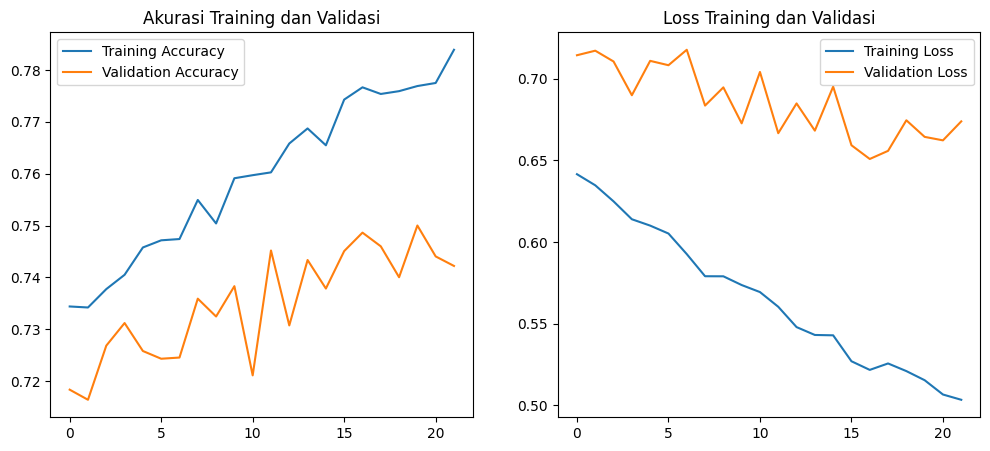

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Training dan Validasi')
plt.legend()

plt.show()

In [38]:
# export_dir = 'saved_model/'
# tf.saved_model.save(model, export_dir)

# tfjs_dir = 'tfjs_model'
# tfjs.converters.save_keras_model(model, tfjs_dir)

In [39]:
# from google.colab import files
# files.download('saved_model')
# files.download('tfjs_model')